# Stanford CS25 Lecture Notes: DeepMind's Perceiver and Perceiver IO

These notes are based on the Stanford CS25 lecture on DeepMind's Perceiver and Perceiver IO architectures, supplemented by the research paper [Perceiver IO: A General Architecture for Structured Inputs & Outputs](https://arxiv.org/pdf/2107.14795.pdf) (Jaegle et al., 2022). They are designed for beginners in machine learning, with simple explanations, visualizations, and interactive code examples to build intuition about these powerful and general-purpose models.

## Introduction

### The Quest for General AI Systems
A central goal in machine learning is to develop systems that can solve a wide array of problems across many different data domains. Think of it like striving for a 'Swiss Army knife' for AI – one tool that can adapt to various challenges. However, many current AI architectures are highly specialized. They often bake in assumptions about the specific type of data they'll see (e.g., 2D structure for images) or the task they need to perform. This specialization means they might not work well, or at all, if you try to apply them to a new, unfamiliar problem, or if the input/output data is very large or complex.

### What Are We Learning About?
This lecture, presented by Drew Jaegle from DeepMind, introduces two related AI models: **Perceiver** and its successor, **Perceiver IO**. These models represent a significant step towards the goal of general-purpose AI. They are designed to handle a vast variety of data types—like images, text, audio, videos, point clouds, and even game states—without needing fundamentally different architectural designs for each one. The core idea is to create a single, flexible architecture that can be applied to many problems with minimal changes.

### Why Is This Exciting? The Promise of Perceiver IO
Imagine a librarian who previously needed separate cataloging systems for books, another for videos, and yet another for musical scores. This would be complex and inefficient. The Perceiver family, and particularly Perceiver IO, is like a universal cataloging system that librarian can use for all types of media. This has several exciting implications:

1.  **Simplicity and Reusability**: Instead of designing a new model from scratch for every new problem, researchers and engineers can potentially use Perceiver IO as a strong starting point. This dramatically simplifies the development process.
2.  **Scalability**: Traditional models, like the Transformer, can struggle with very large inputs (e.g., high-resolution images, long videos, or extensive text documents) because their computational cost grows very quickly with input size. Perceiver IO is designed to scale linearly with input and output size, making it feasible to work with much larger and more complex data.
3.  **Handling Arbitrary Inputs and Outputs**: Real-world tasks often involve diverse inputs and require structured, complex outputs. For instance, understanding a scene might involve processing an image and audio simultaneously, and the output might be a textual description, object locations, and predicted future actions. Perceiver IO is built to manage such arbitrary data configurations.
4.  **Reduced Domain-Specific Engineering**: Many successful AI models rely on components tailored to specific data types (e.g., convolutional layers for images, recurrent layers for sequences). Perceiver IO aims to reduce this reliance, using more general mechanisms like attention for most of its processing.
5.  **Unified Approach to Multimodality and Multitasking**: Perceiver IO provides a natural way to combine information from different modalities (e.g., vision and language) and to train a single model to perform multiple tasks simultaneously.

The original **Perceiver** demonstrated a remarkable ability to handle diverse input modalities. **Perceiver IO** builds upon this by introducing a flexible mechanism to produce outputs of various sizes and structures, making it a truly general-purpose architecture.

### Goals of These Notes
- **Explain Complex Ideas Simply**: Break down the core concepts of Perceiver and Perceiver IO into digestible pieces, avoiding unnecessary jargon where possible.
- **Visualize Concepts**: Use examples, analogies, and diagrams (both drawn and code-generated) to make abstract architectural ideas more concrete.
- **Illustrate with Code**: Provide simple, interactive Python code snippets to demonstrate key mechanisms and build intuition.
- **Comprehensive Coverage**: Cover the key topics from both the lecture and the research paper, focusing on the innovations of Perceiver IO and its capabilities.
- **In-depth Understanding**: Go beyond surface-level descriptions to explore *how* and *why* these models are designed the way they are, and what makes them effective.

## Understanding Traditional Models: Transformers

Before diving into Perceiver, it's helpful to understand one of its key influences and a dominant architecture in many AI fields today: the **Transformer** (Vaswani et al., 2017).

### What Are Transformers?
Transformers are a type of neural network architecture that has revolutionized fields like Natural Language Processing (NLP) and is increasingly used in computer vision, speech recognition, and more. Their core innovation is the **self-attention mechanism**.

**Self-Attention: The Core Idea**
Attention allows the model to weigh the importance of different parts of the input data when making a prediction or generating an output. In *self*-attention, the model looks at other parts of the *same* input sequence to get a better understanding of each part.

**Example**: When translating the sentence "The animal didn't cross the street because *it* was too tired," a Transformer's self-attention mechanism can help determine that "it" refers to "the animal" and not "the street."

**How Attention Works (Simplified QKV Analogy):**
Imagine you're at a library looking for information (this is your **Query**).
1.  Each book on the shelf has a title or a label (these are the **Keys**).
2.  You compare your query to each key to see how relevant it is. This gives you a set of scores (attention scores).
3.  Based on these scores, you decide how much attention to pay to each book's content (the **Values**).
4.  You then combine the content of the books, weighted by their relevance, to get your final piece of information.

In a Transformer, for each input element (e.g., a word in a sentence, a patch in an image):
- It generates a **Query (Q)** vector.
- It generates a **Key (K)** vector.
- It generates a **Value (V)** vector.

The attention scores are calculated by taking the dot product of the Query of one element with the Keys of all other elements. These scores are then normalized (often using softmax) to get attention weights. Finally, these weights are used to compute a weighted sum of the Value vectors, producing the output for that element.

### Limitations of Standard Transformers
Despite their power, standard Transformers have some significant limitations, particularly when dealing with very large inputs or diverse data types:

1.  **Quadratic Scalability Issue (O(N²))**: The self-attention mechanism, in its standard form, compares every input element with every other input element. If you have `N` input elements (e.g., `N` words in a sentence or `N` pixels in an image), calculating all these pairwise interactions requires `N * N = N²` operations. This is known as quadratic complexity.
    - **Impact**: For small `N`, this is manageable. But for large `N`, `N²` grows very rapidly. For example:
        - A 256x256 image has 65,536 pixels. `N²` would be over 4 billion operations *per attention head, per layer*.
        - A long document with 10,000 words would lead to 100 million interactions.
    - This makes standard Transformers computationally very expensive (in terms of both time and memory) for high-resolution images, long videos, or lengthy text documents without some form of preprocessing (like patching images or truncating text).

2.  **Domain-Specific Assumptions & Preprocessing**: To cope with the O(N²) complexity, Transformers often require domain-specific preprocessing. For instance:
    - **Vision Transformers (ViT)** divide images into smaller, fixed-size patches. Attention is then applied to these patches. While effective, this imposes a grid structure.
    - **Language Models** use tokenization to break text into sub-word units, which can introduce its own complexities and biases.
    - These approaches bake in assumptions about the data (e.g., local correlations in images that make patching useful) and limit the model's ability to process truly raw, arbitrary data.

3.  **Fixed Input/Output Structures**: Standard Transformers are often designed for specific input and output structures (e.g., a sequence of tokens in, a sequence of tokens out, or a single classification label out). Adapting them to tasks with very different output structures (like generating a dense optical flow map for every pixel) can be cumbersome and require significant architectural modifications.

These limitations motivated the development of architectures like the Perceiver, which aim to retain the power of attention while overcoming its scalability and generality issues.

## Introducing the Perceiver

The **Perceiver** (Jaegle et al., 2021) was introduced as an architecture to address the scalability limitations of Transformers, particularly for handling large and diverse inputs.

### What Is the Perceiver?
The Perceiver is a model that uses an **asymmetric attention mechanism** to map a potentially very large input (like an image, video, or audio) to a fixed-size **latent space**. This latent representation is then processed by a deep, standard Transformer-style network (using self-attention within the latent space). This design decouples the bulk of the network's computational cost from the size of the input.

**Analogy**: Imagine you have a massive library of books (the input data). Instead of reading every book and comparing it to every other book (like a standard Transformer with very large inputs), you first create a set of detailed summary cards (the latent array). Each summary card is created by carefully cross-referencing relevant parts of the library. Once you have these summary cards, you can do all your complex thinking and reasoning just by working with these cards, without constantly going back to the entire library. This is much more efficient.

### Key Features and Mechanisms of the Original Perceiver

1.  **Cross-Attention for Input Encoding**:
    - The Perceiver uses a **cross-attention** mechanism as its first step. Instead of input elements attending to each other (self-attention), a small, fixed-size array of **latent units** (the latent array) attends to the input elements.
    - Let the input array have `M` elements (e.g., `M` pixels or `M` audio samples) and the latent array have `N` units, where `N` is much smaller than `M` (e.g., `N=512`).
    - The Queries (Q) come from the `N` latent units.
    - The Keys (K) and Values (V) come from the `M` input elements.
    - The complexity of this initial cross-attention is roughly `O(M * N)`, which is linear in the input size `M` (since `N` is fixed and small).
    - This step effectively distills or summarizes information from the large input into the compact latent array.

2.  **Fixed-Size Latent Array**:
    - After the initial cross-attention, all subsequent processing happens on this latent array of size `N`.
    - This means the depth of the processing network doesn't depend on the original input size `M`.

3.  **Deep Latent Processing (Self-Attention Tower)**:
    - The latent array is then processed by a series of standard Transformer blocks (self-attention followed by a feed-forward network).
    - Since these blocks operate on the fixed-size latent array (`N` units), their complexity is `O(N²)`, which is constant with respect to the original input size `M`.
    - This allows for very deep processing without being bottlenecked by large inputs.
    - Some Perceiver variants use weight sharing across these latent Transformer blocks to reduce parameter count.

4.  **Scalability to Large Inputs**:
    - By decoupling the main processing from the input size, Perceivers can handle inputs with hundreds of thousands or even millions of elements (e.g., high-resolution images, raw audio, video frames) much more efficiently than standard Transformers.

5.  **Modality Agnostic (to a degree)**:
    - The core Perceiver architecture makes few assumptions about the input modality. It typically expects the input as a "byte array" – a set of elements, each described by a feature vector. Position information is usually added via positional encodings.

### How Does It Work (Original Perceiver Workflow)?
1.  **Input Preparation**: The input data (e.g., pixels of an image, characters of text) is flattened into a large 1D array of feature vectors. Positional encodings are added to these features to retain spatial or sequential information.
2.  **Initial Cross-Attention (Encoding)**: A learnable latent array (e.g., 512 units) queries the input byte array. Each latent unit attends to the entire input, producing an updated representation for that latent unit. This forms the initial state of the latent array.
3.  **Latent Transformer Processing**: The latent array goes through multiple layers of self-attention (a deep Transformer tower). In each layer, latent units attend to each other, refining their representations.
4.  **Output Generation (Simple Outputs)**: For the original Perceiver, outputs were typically simple, like a classification. This was often achieved by:
    - Averaging the final latent array elements.
    - Passing this average through a linear layer to produce class scores.

### Limitations of the Original Perceiver
While the Perceiver was groundbreaking in handling large and diverse inputs, its original formulation was primarily designed for tasks with **simple, low-dimensional outputs**, such as image classification (predicting a single label) or language modeling (predicting the next token). It lacked a general mechanism to produce complex, structured, high-dimensional outputs like:
- Dense optical flow maps (a 2D vector for every pixel).
- Detailed textual translations or summaries.
- Reconstructing an entire image or video sequence.

This limitation is precisely what **Perceiver IO** was designed to address.

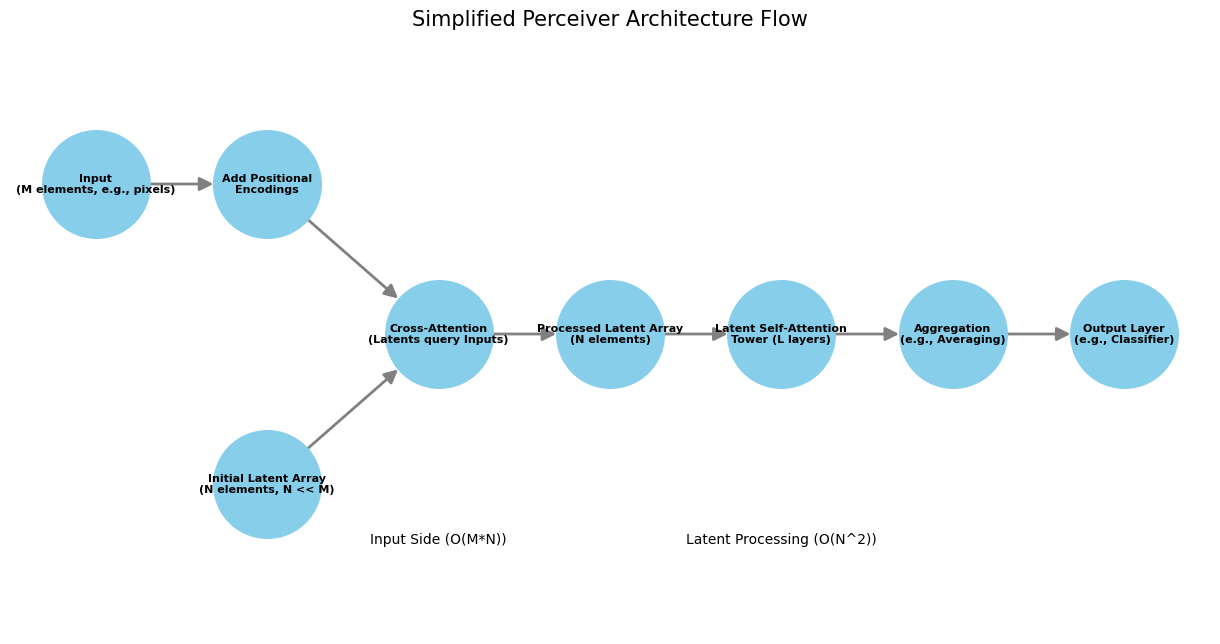

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Create a directed graph for the Perceiver architecture
plt.figure(figsize=(12, 6))
G_perceiver = nx.DiGraph()

# Nodes
nodes_perceiver = {
    'Input_M': 'Input\n(M elements, e.g., pixels)',
    'Pos_Enc_Input': 'Add Positional\nEncodings',
    'Latent_Array_N_init': 'Initial Latent Array\n(N elements, N << M)',
    'Cross_Attention': 'Cross-Attention\n(Latents query Inputs)',
    'Latent_Array_N_proc': 'Processed Latent Array\n(N elements)',
    'Self_Attention_Tower': 'Latent Self-Attention\nTower (L layers)',
    'Aggregation': 'Aggregation\n(e.g., Averaging)',
    'Output_Classifier': 'Output Layer\n(e.g., Classifier)'
}
G_perceiver.add_nodes_from(nodes_perceiver.keys())

# Edges
edges_perceiver = [
    ('Input_M', 'Pos_Enc_Input'),
    ('Pos_Enc_Input', 'Cross_Attention'),
    ('Latent_Array_N_init', 'Cross_Attention'),
    ('Cross_Attention', 'Latent_Array_N_proc'),
    ('Latent_Array_N_proc', 'Self_Attention_Tower'),
    ('Self_Attention_Tower', 'Aggregation'),
    ('Aggregation', 'Output_Classifier')
]
G_perceiver.add_edges_from(edges_perceiver)

# Positions for layout
pos_perceiver = {
    'Input_M': np.array([0, 1]),
    'Pos_Enc_Input': np.array([1,1]),
    'Latent_Array_N_init': np.array([1, 0]),
    'Cross_Attention': np.array([2, 0.5]),
    'Latent_Array_N_proc': np.array([3, 0.5]),
    'Self_Attention_Tower': np.array([4, 0.5]),
    'Aggregation': np.array([5, 0.5]),
    'Output_Classifier': np.array([6, 0.5])
}

# Draw the graph
node_labels = {k: v.replace('\n', '\n') for k,v in nodes_perceiver.items()}
nx.draw(G_perceiver, pos_perceiver, labels=node_labels, with_labels=True,
        node_color='skyblue', node_size=6000, font_size=8, font_weight='bold',
        width=2, arrowsize=20, edge_color='gray')

plt.title('Simplified Perceiver Architecture Flow', size=15)
plt.text(2, -0.2, 'Input Side (O(M*N))', ha='center', size=10)
plt.text(4, -0.2, 'Latent Processing (O(N^2))', ha='center', size=10)
plt.xlim(-0.5, 6.5)
plt.ylim(-0.5, 1.5)
plt.axis('off') # Turn off the axis
plt.savefig('perceiver_architecture_detailed.png')
plt.show()

## Perceiver IO: Handling Complex Inputs & Outputs

**Perceiver IO** (Jaegle et al., 2022) builds directly on the Perceiver, retaining its ability to handle large and diverse inputs efficiently. Its key innovation is a **flexible querying mechanism** that enables it to produce complex, structured outputs of various sizes and semantics. This makes Perceiver IO a truly general-purpose architecture suitable for a much wider range of tasks than the original Perceiver.

**Analogy Revisited**: If the original Perceiver was a librarian who could efficiently create summary cards (latent array) from a vast library (input), Perceiver IO is that same librarian who can now use those summary cards to not only answer simple questions (classification) but also to write detailed reports (generate text), create maps of the library (semantic segmentation), or even predict which books will be popular next (structured prediction).

### The Read-Process-Write Framework
Perceiver IO operates based on a conceptual **"read-process-write"** framework, implemented using attention mechanisms:

1.  **Read (Encode)**:
    - This stage is analogous to the Perceiver's input encoding. An input array (e.g., image pixels, text tokens, audio samples) is "read" and transformed into a fixed-size latent array.
    - This is done using a **cross-attention module** where the latent array (Queries) attends to the input array (Keys and Values).
    - **Input Array**: `X_input` of shape `(M, C_input)` where `M` is the number of input elements and `C_input` is their feature dimension.
    - **Latent Array**: `Z` of shape `(N, D_latent)` where `N` is the number of latent units and `D_latent` is their dimension. `N` is typically much smaller than `M`.
    - This step has complexity linear in `M` (i.e., `O(M*N)`).

2.  **Process**:
    - The latent array `Z` is then refined through a deep stack of **self-attention layers** (Transformer blocks).
    - In these layers, the latent units attend to each other, allowing for complex interactions and feature transformations within this compact latent space.
    - The computation here is independent of the original input size `M` and output size `O`, scaling as `O(L*N²)`, where `L` is the number of processing layers.

3.  **Write (Decode)**:
    - This is the core innovation of Perceiver IO. To produce outputs, a separate **output query array** is defined. This array is specifically constructed for the desired output structure.
    - **Output Query Array**: `Q_output` of shape `(O, D_query)` where `O` is the number of output elements desired, and `D_query` is the dimension of each query.
    - A **cross-attention module** is used again, but this time the `Q_output` array (Queries) attends to the processed latent array `Z` (Keys and Values).
    - The result is an **output array** `Y_output` of shape `(O, D_output)`, where `D_output` is the desired feature dimension for each output element.
    - This step has complexity linear in `O` (i.e., `O(O*N)`).
    - Crucially, the structure and semantics of `Q_output` determine what information is "written" or extracted from the latent space.

### Why is Perceiver IO Better for Complex Outputs?
-   **Flexible Output Generation**: By designing the `Q_output` array appropriately, Perceiver IO can generate outputs of arbitrary size (`O`) and structure. For example:
    -   For **language generation**, `Q_output` could correspond to target token positions.
    -   For **optical flow**, `Q_output` could be associated with each pixel in the output image, perhaps incorporating its 2D coordinates.
    -   For **multimodal autoencoding**, different parts of `Q_output` could correspond to different modalities to be reconstructed.
-   **Linear Scaling with Input and Output Size**: The overall complexity is roughly `O(M*N + L*N² + O*N)`. Since `N` and `L` are fixed model hyperparameters, this scales linearly with input size `M` and output size `O`.
-   **Domain-Agnostic Latent Processing**: The deep processing (`L*N²` part) happens in a latent space that is agnostic to the specifics of the input and output. The adaptation to specific domains and tasks is largely handled by the initial input encoding (how raw data is turned into the `M x C_input` array + positional encodings) and the design of the output queries.
-   **Decoupling**: The bulk of the network's processing is decoupled from the size and modality-specific details of the input and output. This is key to its generality.

This architecture allows Perceiver IO to serve as a drop-in replacement for a wide range of specialist networks, simplifying pipelines and reducing the need for domain-specific architectural assumptions.

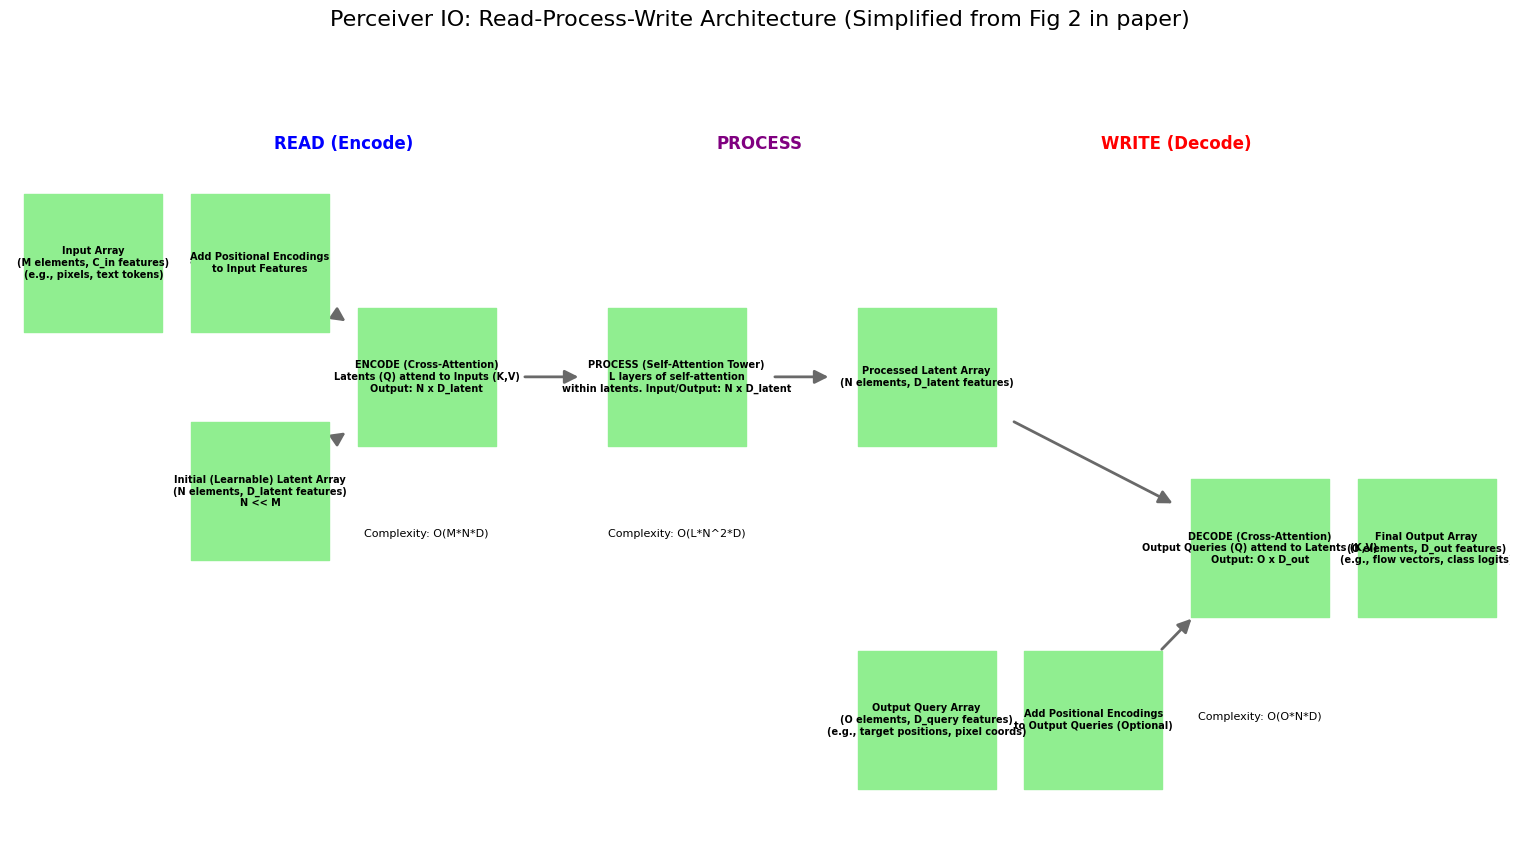

M: Number of input elements, C_in: Input feature dimension
N: Number of latent units, D_latent: Latent feature dimension
L: Number of processing layers in the latent transformer
O: Number of output elements, D_query: Output query feature dimension, D_out: Output feature dimension
This visualization is a high-level schematic. For full architectural details of attention blocks, refer to the paper's Appendix E and Figure 5.


In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

plt.figure(figsize=(15, 8))
G_pio = nx.DiGraph()

# Nodes with detailed descriptions
nodes_pio = {
    'Input_M_C': 'Input Array\n(M elements, C_in features)\n(e.g., pixels, text tokens)',
    'Pos_Enc_In': 'Add Positional Encodings\nto Input Features',
    'Latent_N_D_init': 'Initial (Learnable) Latent Array\n(N elements, D_latent features)\nN << M',
    'Encoder_XAttn': 'ENCODE (Cross-Attention)\nLatents (Q) attend to Inputs (K,V)\nOutput: N x D_latent',
    'Processed_Latent_N_D': 'Processed Latent Array\n(N elements, D_latent features)',
    'Processor_SelfAttn': 'PROCESS (Self-Attention Tower)\nL layers of self-attention\nwithin latents. Input/Output: N x D_latent',
    'Output_Query_O_Dq': 'Output Query Array\n(O elements, D_query features)\n(e.g., target positions, pixel coords)',
    'Pos_Enc_Out': 'Add Positional Encodings\nto Output Queries (Optional)',
    'Decoder_XAttn': 'DECODE (Cross-Attention)\nOutput Queries (Q) attend to Latents (K,V)\nOutput: O x D_out',
    'Output_O_Dout': 'Final Output Array\n(O elements, D_out features)\n(e.g., flow vectors, class logits)'
}
G_pio.add_nodes_from(nodes_pio.keys())

# Edges
edges_pio = [
    ('Input_M_C', 'Pos_Enc_In'),
    ('Pos_Enc_In', 'Encoder_XAttn'),
    ('Latent_N_D_init', 'Encoder_XAttn'),
    ('Encoder_XAttn', 'Processor_SelfAttn'),
    ('Processor_SelfAttn', 'Processed_Latent_N_D'), # Self-attention output IS the processed latent
    ('Processed_Latent_N_D', 'Decoder_XAttn'),
    ('Output_Query_O_Dq', 'Pos_Enc_Out'),
    ('Pos_Enc_Out', 'Decoder_XAttn'),
    ('Decoder_XAttn', 'Output_O_Dout')
]
G_pio.add_edges_from(edges_pio)

# Positions for layout - arranging them in a read-process-write flow
pos_pio = {
    'Input_M_C': np.array([0, 2]),
    'Pos_Enc_In': np.array([1, 2]),
    'Latent_N_D_init': np.array([1, 1]),
    'Encoder_XAttn': np.array([2, 1.5]),
    'Processor_SelfAttn': np.array([3.5, 1.5]),
    'Processed_Latent_N_D': np.array([5, 1.5]),
    'Output_Query_O_Dq': np.array([5, 0]),
    'Pos_Enc_Out': np.array([6,0]),
    'Decoder_XAttn': np.array([7, 0.75]),
    'Output_O_Dout': np.array([8, 0.75])
}

# Draw the graph
node_labels_pio = {k: v.replace('\n', '\n') for k,v in nodes_pio.items()}
nx.draw(G_pio, pos_pio, labels=node_labels_pio, with_labels=True,
        node_color='lightgreen', node_size=10000, font_size=7, font_weight='bold',
        width=2, arrowsize=20, edge_color='dimgray', node_shape='s') # s for square

plt.title('Perceiver IO: Read-Process-Write Architecture (Simplified from Fig 2 in paper)', size=16)
plt.text(1.5, 2.5, 'READ (Encode)', ha='center', size=12, color='blue', weight='bold')
plt.text(4, 2.5, 'PROCESS', ha='center', size=12, color='purple', weight='bold')
plt.text(6.5, 2.5, 'WRITE (Decode)', ha='center', size=12, color='red', weight='bold')

plt.text(2, 0.8, 'Complexity: O(M*N*D)', ha='center', size=8)
plt.text(3.5, 0.8, 'Complexity: O(L*N^2*D)', ha='center', size=8)
plt.text(7, 0.0, 'Complexity: O(O*N*D)', ha='center', size=8)

plt.xlim(-0.5, 8.5)
plt.ylim(-0.5, 3)
plt.axis('off')
plt.savefig('perceiver_io_architecture.png')
plt.show()

print("M: Number of input elements, C_in: Input feature dimension")
print("N: Number of latent units, D_latent: Latent feature dimension")
print("L: Number of processing layers in the latent transformer")
print("O: Number of output elements, D_query: Output query feature dimension, D_out: Output feature dimension")
print("This visualization is a high-level schematic. For full architectural details of attention blocks, refer to the paper's Appendix E and Figure 5.")

## Technical Details of Perceiver IO

Let's delve deeper into the components that make Perceiver IO work, largely based on standard Transformer building blocks but assembled in a novel way.

### Attention Module Internals (Encoder, Processor, Decoder)
Perceiver IO is constructed from GPT-2-style Transformer attention modules. Each module typically consists of:
1.  **Query-Key-Value (QKV) Attention**: This is the core attention mechanism.
2.  **Multi-Layer Perceptron (MLP)**: A small feed-forward network applied independently to each element after attention.
3.  **Layer Normalization and Residual Connections**: These are standard techniques to help with training deep networks.

**QKV Attention Operation (General Form):**
Given a **query input array `X_Q`** (shape `N_q x D_q`) and a **key-value input array `X_KV`** (shape `N_kv x D_kv`):

1.  **Projections**: `X_Q` and `X_KV` are linearly projected to form Queries (Q), Keys (K), and Values (V):
    -   `Q = X_Q @ W_Q` (shape `N_q x D_f`)
    -   `K = X_KV @ W_K` (shape `N_kv x D_f`)
    -   `V = X_KV @ W_V` (shape `N_kv x D_f`)
    Where `W_Q, W_K, W_V` are learnable weight matrices, and `D_f` is the shared feature dimension for attention.

2.  **Attention Scores**: Scores are computed, typically using scaled dot-product attention:
    -   `Scores = (Q @ K.T) / sqrt(D_f)` (shape `N_q x N_kv`)

3.  **Attention Weights**: Softmax is applied row-wise to the scores:
    -   `Weights = softmax(Scores)` (shape `N_q x N_kv`)

4.  **Weighted Sum**: The weights are used to compute a weighted sum of the Values:
    -   `AttentionOutput = Weights @ V` (shape `N_q x D_f`)

5.  **Final Projection (Optional but common)**: The `AttentionOutput` can be projected again with `W_O`.

**How this applies to Perceiver IO's components:**
-   **Encoder (Cross-Attention)**:
    -   `X_Q` is the (learnable) latent array.
    -   `X_KV` is the (possibly position-encoded) input array.
-   **Processor (Self-Attention)**:
    -   `X_Q` is the current state of the latent array.
    -   `X_KV` is also the current state of the latent array (i.e., Q, K, V all derive from the same source).
-   **Decoder (Cross-Attention)**:
    -   `X_Q` is the output query array.
    -   `X_KV` is the processed latent array from the Processor stage.

**Full Attention Module Structure (from Appendix E.1 of the paper):**
A typical full attention module, including residuals and MLP, might look like this (simplified):
```
def attention_module(X_query_input, X_key_value_input):
    # Apply LayerNorm before attention for stability
    normed_X_query = layer_norm(X_query_input)
    normed_X_key_value = layer_norm(X_key_value_input)
    
    # QKV attention (as described above)
    attn_out = qkv_attention(normed_X_query, normed_X_key_value)
    
    # First residual connection (add input query)
    # Note: This specific residual might be omitted in the decoder if X_query_input has very different semantics than attn_out
    res_out_1 = attn_out + X_query_input
    
    # Apply LayerNorm before MLP
    normed_res_out_1 = layer_norm(res_out_1)
    
    # MLP (typically 2 layers with a GELU activation)
    mlp_out = mlp(normed_res_out_1)
    
    # Second residual connection
    final_out = mlp_out + res_out_1
    return final_out
```
The paper notes that the first residual connection (`attn_out + X_query_input`) might sometimes be omitted in the decoder, especially if the query features (e.g., raw input features for optical flow) have very different semantics from the model's output, as adding them could make learning harder.

In [3]:
import numpy as np

def softmax(x, axis=-1):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def simplified_qkv_attention(X_q, X_kv, D_f):
    N_q, D_q_in = X_q.shape
    N_kv, D_kv_in = X_kv.shape

    # Dummy projection matrices (in a real model, these are learned)
    W_Q = np.random.rand(D_q_in, D_f)
    W_K = np.random.rand(D_kv_in, D_f)
    W_V = np.random.rand(D_kv_in, D_f)
    W_O = np.random.rand(D_f, D_q_in) # Output projection back to query dim for residual

    Q = X_q @ W_Q
    K = X_kv @ W_K
    V = X_kv @ W_V

    scores = (Q @ K.T) / np.sqrt(D_f)
    weights = softmax(scores)
    attention_output_raw = weights @ V
    attention_output_projected = attention_output_raw @ W_O # Final projection

    print(f"Query shape: {Q.shape}, Key shape: {K.shape}, Value shape: {V.shape}")
    print(f"Scores shape: {scores.shape}")
    print(f"Weights shape: {weights.shape}")
    print(f"Attention output (raw) shape: {attention_output_raw.shape}")
    print(f"Attention output (projected) shape: {attention_output_projected.shape}")
    return attention_output_projected

# Example: Simulating Encoder Cross-Attention
print("--- Simulating Encoder Cross-Attention ---")
M_elements = 1000  # Number of input elements (e.g., pixels)
C_input_dim = 32   # Feature dimension of input elements
N_latents = 64     # Number of latent units
D_latent_dim = 128 # Dimension of latent units (also D_q_in for latents)
D_f_attention = 64 # Shared feature dimension for attention Q,K,V heads

input_array = np.random.rand(M_elements, C_input_dim) # This would be X_kv
latent_array_queries = np.random.rand(N_latents, D_latent_dim) # This would be X_q

encoder_output = simplified_qkv_attention(latent_array_queries, input_array, D_f_attention)
print(f"Encoder output (updated latents) shape: {encoder_output.shape}\n") # Should be N_latents x D_latent_dim

# Example: Simulating Processor Self-Attention
print("--- Simulating Processor Self-Attention ---")
processed_latents_input = encoder_output # Output from encoder becomes input here
# For self-attention, X_q and X_kv are the same
processor_output = simplified_qkv_attention(processed_latents_input, processed_latents_input, D_f_attention)
print(f"Processor output (further refined latents) shape: {processor_output.shape}\n")

# Example: Simulating Decoder Cross-Attention
print("--- Simulating Decoder Cross-Attention ---")
O_outputs = 500    # Number of desired output elements (e.g., target tokens, output pixels)
D_query_dim = 96   # Dimension of output queries

output_query_array = np.random.rand(O_outputs, D_query_dim) # This is X_q for decoder
latents_from_processor = processor_output # This is X_kv for decoder

decoder_output = simplified_qkv_attention(output_query_array, latents_from_processor, D_f_attention)
print(f"Decoder output (final model output) shape: {decoder_output.shape}") # Should be O_outputs x D_query_dim

--- Simulating Encoder Cross-Attention ---
Query shape: (64, 64), Key shape: (1000, 64), Value shape: (1000, 64)
Scores shape: (64, 1000)
Weights shape: (64, 1000)
Attention output (raw) shape: (64, 64)
Attention output (projected) shape: (64, 128)
Encoder output (updated latents) shape: (64, 128)

--- Simulating Processor Self-Attention ---
Query shape: (64, 64), Key shape: (64, 64), Value shape: (64, 64)
Scores shape: (64, 64)
Weights shape: (64, 64)
Attention output (raw) shape: (64, 64)
Attention output (projected) shape: (64, 128)
Processor output (further refined latents) shape: (64, 128)

--- Simulating Decoder Cross-Attention ---
Query shape: (500, 64), Key shape: (64, 64), Value shape: (64, 64)
Scores shape: (500, 64)
Weights shape: (500, 64)
Attention output (raw) shape: (500, 64)
Attention output (projected) shape: (500, 96)
Decoder output (final model output) shape: (500, 96)


### Latent Array (`N x D`)
-   The **latent array** is central to Perceiver IO's efficiency. It has `N` latent units (or tokens/elements) and each unit has a dimension `D`.
-   `N` (number of latents) and `D` (latent dimension) are crucial hyperparameters.
    -   `N` determines the bottleneck size. A smaller `N` means more compression of information but potentially less capacity. Typical values might be 256, 512, or 1024.
    -   `D` is the feature dimension within the latent space. Typical values could be 768, 1024, 1280, 1536.
-   The initial state of the latent array for the encoder is often a learnable parameter, initialized randomly and then updated during training.

### Positional Encodings
Attention mechanisms, by default, are permutation-invariant; they don't inherently know the order or position of elements. To provide this crucial information, positional encodings are added to the input features.

-   **Why Needed?**: For images, the model needs to know where a pixel is. For text, it needs to know the order of words. Without this, "cat sat on mat" and "mat sat on cat" would look the same to the attention mechanism after initial embedding.
-   **Types Used in Perceiver IO** (as per Appendix G and main text):
    1.  **Fourier Features**: For continuous inputs like images or audio, Perceiver IO often uses Fourier features. These are sine and cosine functions of different frequencies applied to the coordinates of the input elements (e.g., (x,y) for pixels, time `t` for audio, (x,y,t) for video).
        -   Coordinates are typically scaled to `[-1, 1]` range.
        -   A set of frequencies are chosen (e.g., linearly spaced from a minimum to the Nyquist frequency).
        -   This creates a fixed, rich encoding of position that can help the model learn about spatial relationships and frequencies.
    2.  **Learned Positional Encodings**: For some tasks, especially with discrete inputs or when a fixed encoding is less suitable, the model can learn a unique embedding for each position. This is common in language models (e.g., an embedding for position 1, position 2, etc.) and was also explored for ImageNet in Perceiver IO (giving no privileged 2D info).
    3.  **Concatenation/Addition**: These positional features are typically concatenated or added to the semantic features of the input elements.

**Visualization of Fourier Features**: The code below generates a simplified 1D Fourier positional encoding, similar to what might be used for a sequence or one dimension of an image.

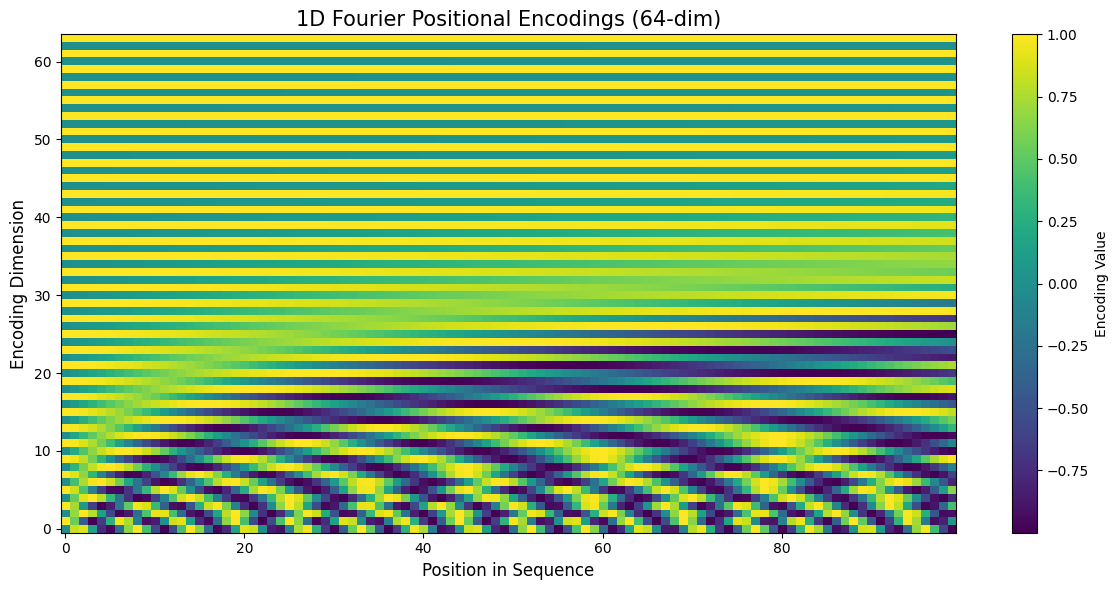

Each row in the plot represents a dimension of the positional encoding.
Each column represents a position in the input sequence.
Notice the wave-like patterns, with different frequencies along the dimension axis.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def fourier_position_encoding_1d(num_positions, encoding_dim, max_freq_scale=10000.0):
    """
    Generates 1D Fourier positional encodings.
    num_positions: The number of positions in the sequence (e.g., sequence length).
    encoding_dim: The desired dimensionality of the encoding vector for each position.
    max_freq_scale: A scaling factor for frequencies, similar to Vaswani et al. 2017.
    """
    assert encoding_dim % 2 == 0, "Encoding dimension must be even for sin/cos pairs."

    position = np.arange(num_positions)[:, np.newaxis] # Shape: (num_positions, 1)
    div_term = np.exp(np.arange(0, encoding_dim, 2) * -(np.log(max_freq_scale) / encoding_dim)) # Shape: (encoding_dim/2,)

    encodings = np.zeros((num_positions, encoding_dim))
    encodings[:, 0::2] = np.sin(position * div_term) # Apply to even indices
    encodings[:, 1::2] = np.cos(position * div_term) # Apply to odd indices

    return encodings

# Parameters for the visualization
num_sequence_positions = 100  # e.g., a sequence of 100 tokens
feature_encoding_dimension = 64   # Each position will be encoded into a 64-dim vector

# Generate the encodings
pos_encodings = fourier_position_encoding_1d(num_sequence_positions, feature_encoding_dimension)

# Visualize the encodings
plt.figure(figsize=(12, 6))
plt.imshow(pos_encodings.T, aspect='auto', cmap='viridis', origin='lower') # Transpose for better visualization
plt.title(f'1D Fourier Positional Encodings ({feature_encoding_dimension}-dim)', size=15)
plt.xlabel('Position in Sequence', size=12)
plt.ylabel('Encoding Dimension', size=12)
plt.colorbar(label='Encoding Value')
plt.tight_layout()
plt.savefig('fourier_encodings_1d.png')
plt.show()

print("Each row in the plot represents a dimension of the positional encoding.")
print("Each column represents a position in the input sequence.")
print("Notice the wave-like patterns, with different frequencies along the dimension axis.")

### Decoding the Latent Representation with an Output Query Array (Sec 3.2 of Paper)
This is the most crucial part that distinguishes Perceiver IO from the original Perceiver and enables its general-purpose output capabilities.

The goal is to produce a final output array `Y` of shape `O x E_out` (where `O` is the number of output elements, `E_out` is their feature dimension), given the processed latent representation `Z` (shape `N x D`).

This is achieved by **querying the decoder with an output query array** `Q_out` of shape `O x E_query`.

**Constructing Output Queries:**
The key is that the `Q_out` array is specifically designed for the task and the desired output structure. Each of the `O` query vectors in `Q_out` contains information relevant to one of the `O` desired output elements. The paper illustrates several ways to construct these queries (see Figure 3 in the paper):

1.  **Simple Classification (e.g., ImageNet):**
    -   `O = 1` (a single output is needed for the class logits).
    -   `Q_out` can be a single, learnable embedding vector. This vector learns to query the latent array `Z` for information relevant to classification.

2.  **Sequence Outputs (e.g., Masked Language Modeling, Translation):**
    -   `O` is the number of tokens in the output sequence.
    -   Each query in `Q_out` can be a positional encoding (e.g., learned or Fourier) corresponding to a target position in the output sequence. For example, to predict the 5th word, the query would be the positional encoding for position 5.

3.  **Dense Spatial Outputs (e.g., Optical Flow, Semantic Segmentation):**
    -   `O` is the number of pixels in the output image (e.g., `Height * Width`).
    -   Each query in `Q_out` can be formed by:
        -   A positional encoding (e.g., 2D Fourier features) of the (x,y) coordinates of the corresponding output pixel.
        -   Optionally, for tasks like optical flow, the paper found it helpful to also include the *input features* at that (x,y) location as part of the query. This helps the model associate the output with the input content at that specific location.

4.  **Multi-task or Multi-modal Outputs:**
    -   `Q_out` can be constructed by combining positional information with task-specific or modality-specific learned embeddings.
    -   For example, in multi-task GLUE, each task might have a unique learned task embedding. The output query would be this task embedding (if a single output per task is needed).
    -   For multimodal autoencoding (e.g., reconstructing video, audio, and a label), the query for a video pixel would include its (x,y,t) positional encoding + a learned "video modality" embedding. The query for an audio sample would include its `t` positional encoding + a learned "audio modality" embedding.

5.  **Symbolic Outputs (e.g., StarCraft II unit selection):**
    -   `O` is the number of units.
    -   The query for each unit's output can be the input feature vector representing that unit. This directly associates the model's output with the corresponding input unit.

**The Decoding Process:**
Once `Q_out` is constructed, it acts as the Query input to a final cross-attention layer, where the Keys and Values are derived from the processed latent array `Z`. The output of this attention layer is the final model output `Y`.

**Key Advantages of this Querying System:**
-   **Flexibility**: Arbitrarily sized and structured outputs can be generated.
-   **Parallel Decoding**: Each of the `O` output elements can be decoded in parallel because its computation only depends on its specific query and the shared latent array `Z`.
-   **Amortized Training for Large Outputs**: For tasks with extremely large `O` (e.g., high-resolution video), it's often too expensive to compute the loss over all `O` output points at every training step. Instead, during training, a *subset* of the output points can be randomly sampled, their corresponding queries used for decoding, and the loss computed only on this subset. At test time, the full output array can be generated (possibly in batches if `O` is very large).

The paper notes that even very simple query features can produce good results, suggesting the latent attention process effectively organizes information in an easily queryable manner.

Classification: 1 query, shape (1, 512)
Output for classification (e.g., logits): (1, 64)

Language Modeling: 10 queries, shape (10, 512)
Output for language modeling (e.g., token embeddings): (10, 64)

Optical Flow: 64 queries for 8x8 grid, shape (64, 512)
Output for optical flow (e.g., flow vectors): (64, 64)


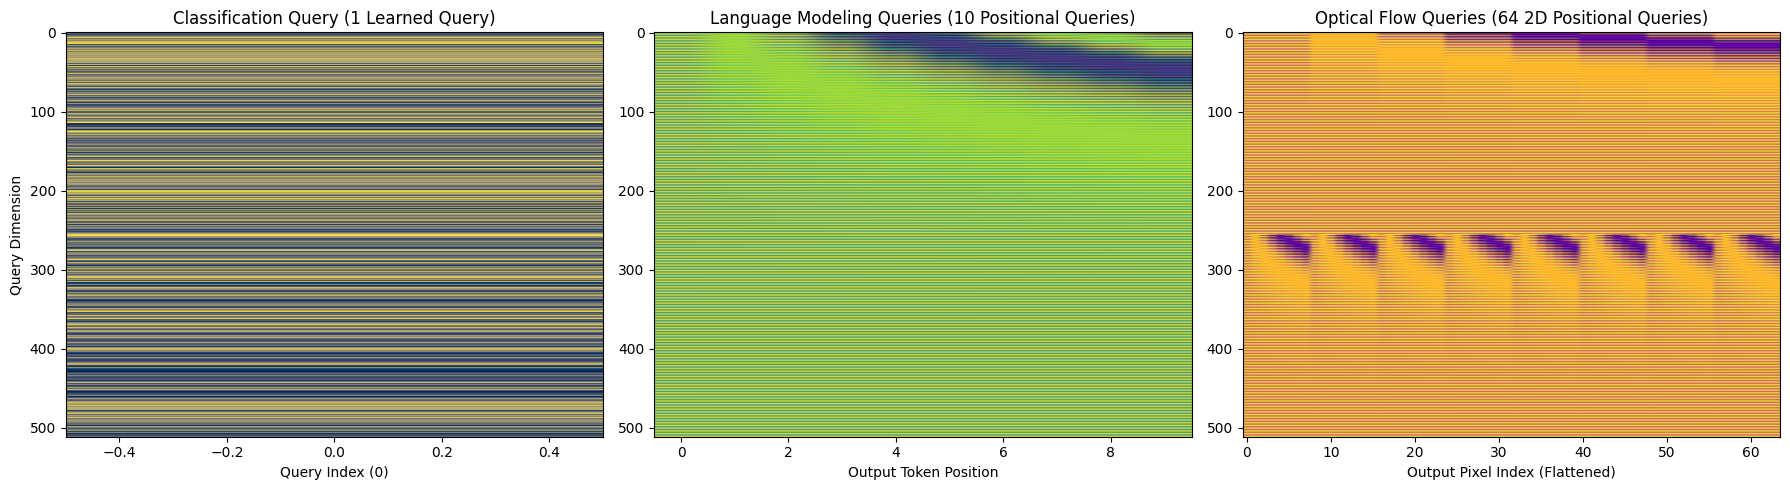

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate processed latent array (output from the 'Process' stage)
N_latents = 256
D_latent_dim = 512
processed_latent_Z = np.random.rand(N_latents, D_latent_dim)

def simplified_qkv_attention(queries, keys_values, D_f_attention):
    # Simulated attention mechanism (simplified for demonstration)
    # queries: (O, D_q), keys_values: (N, D_kv)
    # In real implementations, queries, keys, values are projected

    # Random projections for demonstration (instead of learned weights)
    D_q = queries.shape[1]
    D_kv = keys_values.shape[1]
    W_q = np.random.randn(D_q, D_f_attention)
    W_k = np.random.randn(D_kv, D_f_attention)
    W_v = np.random.randn(D_kv, D_f_attention)

    # Project queries, keys, values
    Q = np.dot(queries, W_q)
    K = np.dot(keys_values, W_k)
    V = np.dot(keys_values, W_v)

    # Scaled dot-product attention
    attn_scores = np.dot(Q, K.T) / np.sqrt(D_f_attention)
    attn_weights = np.exp(attn_scores) / np.sum(np.exp(attn_scores), axis=-1, keepdims=True)  # Softmax
    output = np.dot(attn_weights, V)
    return output


def generate_output_queries(task_type, output_shape, query_dim):
    if task_type == "classification":
        # Single learnable query for classification
        O_outputs = 1
        # In a real model, this would be a learnable nn.Parameter
        queries = np.random.rand(O_outputs, query_dim)
        print(f"Classification: {O_outputs} query, shape {queries.shape}")
        return queries

    elif task_type == "language_modeling":
        # Positional queries for a sequence of length output_shape[0]
        O_outputs = output_shape[0] # sequence length
        # Using simplified 1D Fourier encodings as queries
        if query_dim % 2 != 0: query_dim +=1 # Ensure even for Fourier
        queries = fourier_position_encoding_1d(O_outputs, query_dim)
        print(f"Language Modeling: {O_outputs} queries, shape {queries.shape}")
        return queries

    elif task_type == "optical_flow":
        # 2D positional queries for HxW output
        H, W = output_shape
        O_outputs = H * W
        # Simulate 2D positional encodings (e.g., concat 1D Fourier for x and y)
        # This is a simplification; real 2D Fourier features are more complex.
        if query_dim % 4 != 0 : query_dim = (query_dim//4 + 1)*4 # Ensure div by 4 for 2x 1D
        pos_x = fourier_position_encoding_1d(W, query_dim // 2)
        pos_y = fourier_position_encoding_1d(H, query_dim // 2)
        queries = np.zeros((O_outputs, query_dim))
        idx = 0
        for r in range(H):
            for c in range(W):
                queries[idx, :query_dim//2] = pos_y[r, :]
                queries[idx, query_dim//2:] = pos_x[c, :]
                # In real optical flow, input features at (r,c) might also be added here
                idx += 1
        print(f"Optical Flow: {O_outputs} queries for {H}x{W} grid, shape {queries.shape}")
        return queries
    else:
        raise ValueError("Unknown task type")

# --- Example 1: Classification Output Query ---
task1_query_dim = D_latent_dim # Often query dim matches latent dim for decoder
classification_queries = generate_output_queries("classification", None, task1_query_dim)
# Dummy decode step (replace with actual cross-attention)
classification_output = simplified_qkv_attention(classification_queries, processed_latent_Z, D_f_attention=64)
print(f"Output for classification (e.g., logits): {classification_output.shape}\n")

# --- Example 2: Language Modeling Output Queries (e.g., for 10 tokens) ---
seq_len = 10
task2_query_dim = D_latent_dim
lm_queries = generate_output_queries("language_modeling", (seq_len,), task2_query_dim)
lm_output = simplified_qkv_attention(lm_queries, processed_latent_Z, D_f_attention=64)
print(f"Output for language modeling (e.g., token embeddings): {lm_output.shape}\n")

# --- Example 3: Optical Flow Output Queries (e.g., for a 8x8 grid) ---
H, W = 8, 8
task3_query_dim = D_latent_dim
flow_queries = generate_output_queries("optical_flow", (H,W), task3_query_dim)
flow_output = simplified_qkv_attention(flow_queries, processed_latent_Z, D_f_attention=64)
print(f"Output for optical flow (e.g., flow vectors): {flow_output.shape}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].imshow(classification_queries.T, aspect='auto', cmap='cividis')
axes[0].set_title('Classification Query (1 Learned Query)')
axes[0].set_xlabel('Query Index (0)')
axes[0].set_ylabel('Query Dimension')

axes[1].imshow(lm_queries.T, aspect='auto', cmap='viridis')
axes[1].set_title(f'Language Modeling Queries ({seq_len} Positional Queries)')
axes[1].set_xlabel('Output Token Position')

axes[2].imshow(flow_queries.T, aspect='auto', cmap='plasma')
axes[2].set_title(f'Optical Flow Queries ({H*W} 2D Positional Queries)')
axes[2].set_xlabel('Output Pixel Index (Flattened)')
plt.tight_layout()
plt.savefig('output_query_examples.png')
plt.show()

### Computational Complexity (Appendix E.2 of Paper)
Understanding the computational complexity is key to appreciating Perceiver IO's scalability.

Let:
-   `M`: Number of elements in the input array.
-   `N`: Number of elements (units) in the latent array.
-   `O`: Number of elements in the output array (determined by output queries).
-   `L`: Number of layers in the latent self-attention processor.
-   `D_f`: The effective feature dimension used within the attention mechanisms (Q,K,V projections). For simplicity, let's assume this is proportional to `D_latent` or some consistent feature size `F` across the model components as used in the paper's complexity analysis `O([M + O + LN]NF)` where F seems to be the feature size and the second N is for N heads. Let's simplify to `D` for general feature dimension of latents and `C` for inputs/outputs.

The dominant operations in attention modules are matrix multiplications.

1.  **Encoder (Cross-Attention)**:
    -   Queries from `N` latents, Keys/Values from `M` inputs.
    -   Complexity: `O(M * N * D_f)` (or `O(M * N * F)` in paper's notation if `F` is head dimension and there are `N_heads`, total `D_f = N_heads * F`). Let's use a general `D_f` for simplicity.
    -   This is **linear** in input size `M`.

2.  **Processor (Self-Attention in Latent Space)**:
    -   `L` layers, each operating on `N` latents attending to `N` latents.
    -   Complexity per layer: `O(N * N * D_f)` or `O(N² * D_f)`.
    -   Total for `L` layers: `O(L * N² * D_f)`.
    -   This is **independent** of input size `M` and output size `O`.

3.  **Decoder (Cross-Attention)**:
    -   Queries from `O` output queries, Keys/Values from `N` latents.
    -   Complexity: `O(O * N * D_f)`.
    -   This is **linear** in output size `O`.

**Overall Complexity of Perceiver IO:**
`Total Complexity ≈ O(M*N*D_f + L*N²*D_f + O*N*D_f)`
This can be factored as `O((M + O + L*N) * N * D_f)` (The paper uses `O([M+O+LN]NF)` where N is index dimension and F is feature size). The key takeaway is the linear dependency on `M` and `O`, and the `L*N²` term for the deep processing which is decoupled from `M` and `O`.

**Comparison with Standard Transformer:**
-   A standard Transformer applied directly to `M` inputs would have a complexity of `O(L * M² * D_f)` (if `M` inputs are processed through `L` layers).
-   Perceiver IO avoids the `M²` term, replacing it with terms linear in `M` and `O`, and a fixed `N²` term for latent processing.

**Advantages:**
-   **Scales to Large M and O**: The linear scaling makes it feasible for very large inputs and outputs where `M²` or `O²` would be prohibitive.
-   **Decouples Depth from Input/Output Size**: The number of processing layers `L` can be made very large without being constrained by `M` or `O`, as `L` only multiplies the `N²` term.

This computational profile is what allows Perceiver IO to be a general-purpose architecture across a wide range of data scales.


### Decoder for Classification/Regression (Appendix E.3 of Paper)
Even for tasks like classification, where the output is simple (e.g., a single vector of class logits), Perceiver IO's attentional decoder offers advantages over the simpler average + project decoder used in the original Perceiver.

1.  **Original Perceiver Decoder (Average + Project)**:
    -   The `N` latent vectors from the final processing layer are averaged to produce a single vector.
    -   This average vector is then passed through a linear layer (projected) to get the final class scores.
    -   **Analogy**: Taking all the summary cards, calculating an average theme, and then making a decision based on that average theme.
    -   **Weighting**: All `N` latents are weighted uniformly (1/N) in the averaging step.

2.  **Perceiver IO Attentional Decoder (for Classification)**:
    -   A single, learnable output query vector is used (as `X_Q`).
    -   This query attends to all `N` latent vectors (as `X_KV`) from the final processing layer.
    -   The attention mechanism computes data-dependent weights for each of the `N` latents.
    -   The output of the QKV attention (a weighted sum of the (projected) latents) is then passed through an MLP to produce the final class scores.
    -   **Analogy**: Having a specific question (the learnable query), and then looking at all summary cards, deciding which ones are most relevant to the question, and combining their information (weighted by relevance) to answer.
    -   **Weighting**: The `N` latents are weighted dynamically based on the learned query and the content of the latents themselves (via attention scores).

**Figure 6 from the paper's Appendix illustrates this difference:**

**(Left Side: Perceiver IO's Attention Decoder for Single Query)**
```mermaid
graph TD
    A[Latents (N x D)] -->|K, V| B(QKV Attention)
    C[Query (1 x D_q)] -->|Q| B
    B -->|Weighted Avg of V| D(MLP)
    D --> E[Output (1 x D_out)]
    subgraph Attention Decoder (Perceiver IO Style)
        direction LR
        A
        C
        B
        D
        E
    end
```

**(Right Side: Original Perceiver's Average + Project Decoder)**
```mermaid
graph TD
    F[Latents (N x D)] --> G(Average Pooling)
    G -->|1 x D| H(Linear Projection)
    H --> I[Output (1 x D_out)]
    subgraph Average + Project Decoder (Original Perceiver Style)
        direction LR
        F
        G
        H
        I
    end
```

**Why is the Attentional Decoder More Expressive?**
-   **Data-Dependent Weighting**: The attentional decoder can learn to selectively focus on the most relevant latent units for the specific task (e.g., classification), rather than treating all latents equally via simple averaging.
-   **More Powerful Transformation**: The QKV attention involves learnable projections (W_Q, W_K, W_V, W_O) and an MLP, allowing for more complex transformations of the latent information before producing the final output, compared to just an average and a single linear layer.
-   **Consistency**: It uses the same architectural pattern (QKV attention + MLP) as the encoder and processor modules, making the overall design more uniform.
-   **Generalizability to Dense Outputs**: The single-query attentional decoder is just a special case of the general multi-query decoder. Increasing the number of queries naturally extends it to dense outputs, which is not straightforward for the average + project method.

The paper reports that this attentional decoder typically yields somewhat better results than the standard average + project decoder even on simple classification tasks (e.g., on ImageNet and AudioSet), supporting its increased expressivity.

## Applications of Perceiver and Perceiver IO

Perceiver IO's generality is demonstrated by its strong performance across a diverse range of tasks and modalities, often with minimal changes to the core architecture. The paper (Section 4 and Appendix) provides details on these applications. For each task, the key adaptation usually involves:
1.  **Input Preprocessing**: How raw data is converted into an `M x C_in` array and how positional/modality encodings are applied.
2.  **Output Query Construction**: How the `O x D_query` array is designed for the specific output structure.
3.  **Hyperparameters**: Such as latent array size (`N`, `D`), number of layers (`L`), etc.

### 1. Language Understanding (Sec 4.1, Appendix F)

-   **Task**: Masked Language Modeling (MLM) pretraining (like BERT) and finetuning on the GLUE benchmark for natural language understanding tasks (e.g., sentiment analysis, textual entailment).
-   **Key Innovation**: Perceiver IO was shown to perform competitively even when operating directly on **raw UTF-8 bytes** of text, without explicit tokenization (which is standard for models like BERT).
    -   **Input**: Sequence of UTF-8 bytes. Each byte embedded, and a learned positional encoding added.
    -   **Output Query (MLM)**: For each masked input byte position, a learned positional query is used to predict the original byte.
    -   **Output Query (GLUE Finetuning)**: For classification tasks, a single learned query (or task-specific queries for multi-task GLUE) is used to predict class logits.
-   **Performance Highlights (Table 1 in paper)**:
    -   **On SentencePiece tokens**: Perceiver IO Base slightly outperformed a BERT Base baseline (81.2 vs. 81.1 GLUE avg.) with a deeper latent processor (26 layers vs. 12) but similar FLOPs due to a smaller latent size (N=256).
    -   **On UTF-8 bytes (tokenizer-free)**:
        -   Perceiver IO (26 layers, N=256) significantly outperformed a byte-level BERT baseline with matching FLOPs (81.0 vs. 71.5 GLUE avg.). This shows Perceiver IO's architectural advantage for longer, raw sequences.
        -   A larger Perceiver IO++ (40 layers, N=256) achieved 81.8 GLUE avg. on bytes, on par with tokenized BERT Base.
-   **Advantages/Insights**:
    -   Perceiver IO's linear scaling with input length makes processing raw byte sequences (which are ~4x longer than tokenized sequences) feasible.
    -   Eliminating tokenizers simplifies the pipeline, removes tokenizer-specific engineering, and avoids issues with out-of-vocabulary words or language-specific tokenization rules.
    -   **Multi-task GLUE (Table 2)**: Perceiver IO with multitask output queries (one query per GLUE task, or a shared query with task-specific heads) outperformed single-task training and matched approaches using special `[CLS]` tokens, demonstrating a more generic multitask handling.
    -   **Learned Query Visualization (Fig 7 in Appendix F)**: The paper visualizes attention weights for the learned output queries in MLM, showing the model learns both position-based and content-based lookups (e.g., focusing on punctuation, capital letters as delimiters).

**Simulated Text Input (Bytes)**

In [7]:
text_example = "Perceiver IO can process raw bytes!"
utf8_bytes = text_example.encode('utf-8')
byte_values = [b for b in utf8_bytes]

print(f"Original Text: '{text_example}'")
print(f"UTF-8 Bytes: {utf8_bytes}")
print(f"Byte Values (Integers): {byte_values}")
print(f"Number of characters: {len(text_example)}")
print(f"Number of UTF-8 bytes: {len(byte_values)}")

# Each byte value would be embedded into a feature vector,
# and a positional encoding would be added.
input_sequence_length_M = len(byte_values)
embedding_dim_C = 768 # Example embedding dimension

# Simulated input features (embeddings + positional encodings)
simulated_input_features = np.random.rand(input_sequence_length_M, embedding_dim_C)
print(f"Shape of input to Perceiver IO Encoder: {simulated_input_features.shape}")

Original Text: 'Perceiver IO can process raw bytes!'
UTF-8 Bytes: b'Perceiver IO can process raw bytes!'
Byte Values (Integers): [80, 101, 114, 99, 101, 105, 118, 101, 114, 32, 73, 79, 32, 99, 97, 110, 32, 112, 114, 111, 99, 101, 115, 115, 32, 114, 97, 119, 32, 98, 121, 116, 101, 115, 33]
Number of characters: 35
Number of UTF-8 bytes: 35
Shape of input to Perceiver IO Encoder: (35, 768)


### 2. Optical Flow (Sec 4.2, Appendix H)

-   **Task**: Given two consecutive video frames, estimate the 2D displacement (flow vector) for each pixel in the first frame, indicating where it moves in the second frame.
-   **Challenges**: Handling large motions, occlusions, textureless regions, and generalizing from synthetic training data (e.g., AutoFlow) to real-world videos (e.g., Sintel, KITTI benchmarks).
-   **Perceiver IO Application**:
    -   **Input**: Two frames are concatenated along the channel dimension. For each pixel in the first frame, a 3x3 patch is extracted around it from both frames (stacked). This results in a `3x3x(Channels_Frame1+Channels_Frame2)` feature vector per pixel. A 2D Fourier positional encoding of the pixel's (x,y) coordinates is concatenated.
    -   **Output Query**: For each pixel (x,y) for which flow is to be predicted, the query is formed by its 2D Fourier positional encoding, *plus* the input patch features (from the step above) at that same (x,y) location.
    -   **Output**: A 2D flow vector (dx, dy) for each queried pixel.
-   **Performance Highlights (Table 3 in paper)**:
    -   Achieved **state-of-the-art results on Sintel.final** (EPE 2.42) and strong results on Sintel.clean (EPE 1.81) and KITTI, outperforming or matching specialized architectures like RAFT and PWCNet when trained on AutoFlow.
    -   This was surprising given Perceiver IO's general nature and lack of explicit mechanisms common in flow networks (e.g., cost volumes, explicit warping, iterative refinement tied to image pyramids).
-   **Advantages/Insights**:
    -   Demonstrates Perceiver IO's ability to handle dense, structured visual outputs without domain-specific architectural biases for multiscale correspondence or iterative refinement.
    -   The model implicitly learns to find correspondences and propagate flow information.
    -   **Ablations (Appendix H, Table 16)** explored different input patch sizes, concatenation strategies, and the use of convolutional downsampling/RAFT-style upsampling. Concatenating frames and using local patch context generally helped. Convolutional preprocessing with RAFT upsampling performed slightly worse but was computationally cheaper.
    -   **Qualitative Results (Fig 8 in Appendix H)** show Perceiver IO handling occlusions and propagating flow across textureless regions well.

**Simulated Optical Flow Visualization (as before, illustrating the output type)**

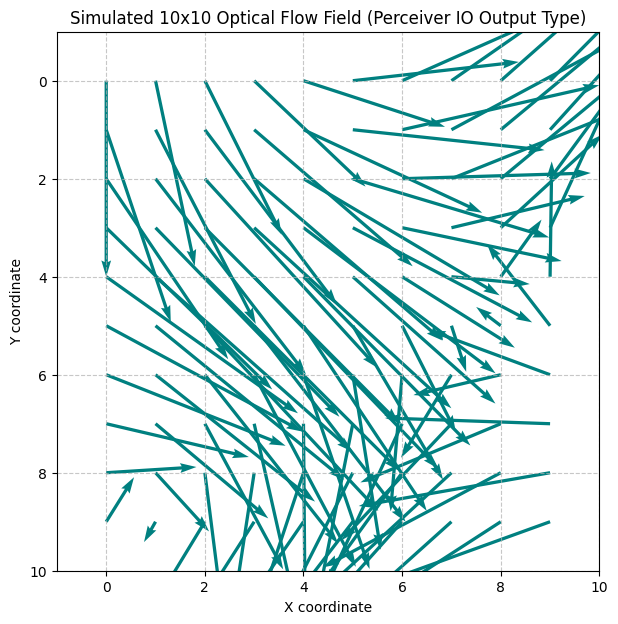

Perceiver IO would output 100 such (dx, dy) vectors for an 10x10 image region.


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate a small grid of optical flow vectors (output from Perceiver IO)
H, W = 10, 10 # Height and width of the flow field
x_coords, y_coords = np.meshgrid(np.arange(W), np.arange(H))

# Simulate dx (horizontal) and dy (vertical) components of flow
dx_flow = np.sin(x_coords / 5 + y_coords / 3) * 2
dy_flow = np.cos(x_coords / 3 - y_coords / 5) * 2

plt.figure(figsize=(7, 7))
plt.quiver(x_coords, y_coords, dx_flow, dy_flow, color='teal', angles='xy', scale_units='xy', scale=0.5)
plt.xlim(-1, W)
plt.ylim(-1, H)
plt.gca().invert_yaxis() # Match image coordinate system
plt.title(f'Simulated {H}x{W} Optical Flow Field (Perceiver IO Output Type)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('optical_flow_output_type.png')
plt.show()

print(f"Perceiver IO would output {H*W} such (dx, dy) vectors for an {H}x{W} image region.")

### 3. Multimodal Autoencoding (Sec 4.3, Appendix I)

-   **Task**: Learn a compressed representation from multiple input modalities (video, audio, class labels) and then reconstruct all of them from this representation. Evaluated on Kinetics-700-2020 dataset.
-   **Challenges**: Combining data of different dimensions (e.g., 3D video, 1D audio, 0D labels) and with vastly different numbers of elements.
-   **Perceiver IO Application**:
    -   **Input**:
        -   Video: 16 frames at 224x224, processed into ~50k 4x4 patches.
        -   Audio: ~30k raw audio samples.
        -   Labels: One-hot encoded class label.
        -   All input elements (video patches, audio samples, label vector) are padded with modality-specific learned embeddings and serialized into a single 2D input array for the encoder.
    -   **Output Query**: For reconstruction:
        -   Video pixels: Queries use 3D Fourier positional encodings + learned video modality embedding.
        -   Audio samples: Queries use 1D Fourier positional encodings + learned audio modality embedding.
        -   Label: Query is a learned label modality embedding.
    -   **Training**: Due to the large output size (>800k points), outputs are subsampled during training (e.g., 512 audio samples, 512 pixels, plus the label). At test time, full outputs are generated.
-   **Performance Highlights (Table 4, Figure 4 in paper)**:
    -   The model successfully reconstructed recognizable video and audio and achieved reasonable classification accuracy from the shared latent space, demonstrating joint representation learning.
    -   Example (88x compression): Audio PSNR 26.97, Video PSNR 24.37, Top-1 Class Accuracy 10.2%.
    -   The paper showed a trade-off: emphasizing video/audio PSNR vs. classification accuracy by changing loss weights. Higher classification accuracy (e.g., 45%) was possible with some hit to reconstruction quality.
-   **Advantages/Insights**:
    -   Showcases Perceiver IO's ability to flexibly handle and integrate highly diverse multimodal data within a single, unified framework.
    -   The querying mechanism allows targeted reconstruction of different modalities from the shared latent space.
    -   Subsampling outputs during training is crucial for managing computational cost with very high-dimensional outputs.

**(Figure 4 in the paper shows example reconstructions: inputs on left, reconstructions on right, for video frames and audio waveforms.)**

### 4. ImageNet Classification (Appendix A)

-   **Task**: Standard image classification on ImageNet (1000 classes).
-   **Perceiver IO Application (Compared to original Perceiver)**:
    -   **Input**: Image pixels. Different variants explored:
        1.  **2D Fourier Features**: Raw pixels + 2D Fourier positional encodings (no convolutions).
        2.  **Learned Positional Features**: Raw pixels + fully learned positional encodings (given no explicit 2D structure information).
        3.  **2D Conv + Maxpool Preprocessing**: A shallow convolutional frontend to extract initial features, which are then fed to Perceiver IO (similar to ViT's patch stem).
    -   **Output Query**: A single, learnable query vector is used to attend to the final latent array to produce class logits (using the attentional decoder discussed earlier).
-   **Performance Highlights (Table 7 in Appendix A)**:
    -   **Perceiver IO vs. Original Perceiver**: Perceiver IO consistently outperformed the original Perceiver (which used average+project pooling) across different input configurations.
        -   e.g., w/ 2D Fourier features: Perceiver IO 79.0% vs. Perceiver 78.6%.
        -   e.g., w/ conv preprocessing: Perceiver IO 82.1% vs. Perceiver 77.4%.
    -   **Without 2D Convolutions (JFT pretrained)**: Perceiver IO (config B, pretrained on JFT-300M) achieved 84.5% top-1 accuracy using only 2D Fourier features as positional encodings, competitive with ViT models that use convolutional patch stems.
    -   **With 2D Conv Preprocessing (JFT pretrained)**: Perceiver IO (config B, conv, pretrained) reached 86.4% top-1 accuracy, close to strong CNNs like NFNet-F6+SAM (86.5%).
    -   **With Learned Positional Features (no 2D info)**: Achieved 72.7% top-1, demonstrating an ability to learn image structure from scratch, though lower than when 2D info is provided via Fourier features or convolutions.
-   **Advantages/Insights**:
    -   The attentional decoder of Perceiver IO is beneficial even for simple classification.
    -   Perceiver IO can achieve strong results on ImageNet without relying on 2D convolutions in its core architecture, showcasing its generality.
    -   It is compatible with convolutional frontends, which can provide a useful inductive bias for images and improve performance/efficiency.
    -   Large-scale pretraining (JFT) significantly boosts performance.
    -   **Training Details (Appendix A.1, A.2)**: Used CutMix, MixUp, RandAugment. LAMB optimizer. For JFT pretraining, a 16-layer latent network was used without weight sharing.

### 5. StarCraft II (Appendix B)

-   **Task**: Replace the Transformer-based 'entity ecoder'module within DeepMind's AlphaStar agent for the complex real-time strategy game StarCraft II.
-   **AlphaStar's Entity Encoder**: Takes a set of game entities (units, buildings) as input (up to 512 entities), each represented by a feature vector (e.g., unit type, health, position). It outputs an updated embedding for each entity and a pooled global state representation.
-   **Perceiver IO Application**:
    -   **Input**: Set of 512 entity feature vectors.
    -   **Latent Array**: A small latent array (e.g., N=32).
    -   **Output Query**: To get the embedding for each of the 512 output entities, the original input feature vector for that entity is used as the query.
-   **Performance Highlights (Table 9 in Appendix B)**:
    -   Perceiver IO (3 layers, N=32) **matched the 87% win rate** of the original, heavily tuned 3-layer Transformer entity encoder in AlphaStar.
    -   Achieved this with a **~3.5x reduction in FLOPs** (0.93B vs. 3.3B) and slightly fewer parameters (140M vs. 144M).
    -   This was achieved with minimal tuning (only sweeping latent size N={32, 64}).
-   **Advantages/Insights**:
    -   Demonstrates Perceiver IO as an efficient and effective drop-in replacement for standard Transformers in complex, symbolic reasoning tasks.
    -   The output querying mechanism (using input features as queries) is well-suited for tasks requiring transforming a set of input items into a corresponding set of output items.
    -   Highlights Perceiver IO's potential for improving efficiency in large-scale reinforcement learning systems.

### 6. AudioSet Classification (Appendix C)

-   **Task**: Multimodal audio event classification using both video frames and audio from the AudioSet dataset (10-second clips, 527 classes).
-   **Perceiver IO Application (Compared to original Perceiver)**:
    -   **Input**: Video frames (e.g., patched) and audio (raw or mel-spectrograms). Modality embeddings and positional encodings applied.
    -   **Output Query**: A single, learnable query vector for class logits (attentional decoder).
-   **Performance Highlights (Table 10 in Appendix C)**:
    -   Perceiver IO consistently provided small but consistent improvements in mean Average Precision (mAP) over the original Perceiver (which used average+project pooling) for both raw audio + video and mel-spectrogram + video inputs.
        -   Raw audio + video: Perceiver IO 43.3 mAP vs. Perceiver 42.4 mAP.
        -   Mel-spectrogram + video: Perceiver IO 44.9 mAP vs. Perceiver 43.6 mAP (with larger D for Perceiver IO).
-   **Advantages/Insights**:
    -   Further confirms that Perceiver IO's attentional decoder is beneficial even for classification tasks compared to the simpler pooling of the original Perceiver.
    -   Reinforces Perceiver IO's strength in multimodal settings.

**Summary of Applications**:
The diverse set of tasks tackled successfully by Perceiver IO—spanning language, vision (dense and classification), audio, multimodal fusion, and symbolic reasoning—underscores its claim as a general-purpose architecture. Its ability to scale efficiently and adapt to varied input/output structures with minimal architectural changes is a significant step forward.

## Comparing Perceiver IO with Other Models

Perceiver IO offers a unique set of advantages and trade-offs when compared to other prominent neural network architectures.

### Perceiver IO vs. Standard Transformers
-   **Scalability (Computational Complexity)**:
    -   **Standard Transformer**: `O(L * M² * D_f)` for `M` inputs and `L` layers. Suffers from quadratic scaling with input size.
    -   **Perceiver IO**: `O((M + O + L*N) * N * D_f)`. Scales linearly with input size `M` and output size `O`. The `L*N²` term for latent processing is decoupled from `M` and `O`.
    -   *Advantage Perceiver IO*: Significantly more scalable to large inputs and outputs.
-   **Input/Output Flexibility**:
    -   **Standard Transformer**: Often designed for sequence-to-sequence or sequence-to-label tasks. Adapting to arbitrary, high-dimensional structured outputs can be non-trivial.
    -   **Perceiver IO**: Explicitly designed with a flexible output querying mechanism to handle arbitrary input and output arrays.
    -   *Advantage Perceiver IO*: More versatile for diverse task structures.
-   **Preprocessing**:
    -   **Standard Transformer**: Often requires domain-specific preprocessing like image patching (ViT) or text tokenization to manage complexity.
    -   **Perceiver IO**: Can process very raw inputs (e.g., UTF-8 bytes, raw pixels with Fourier features) due to its scalability, reducing reliance on heavy preprocessing.
    -   *Advantage Perceiver IO*: Potentially simpler pipelines, less domain-specific engineering.

### Perceiver IO vs. Convolutional Neural Networks (CNNs, e.g., ResNet)
-   **Inductive Biases**:
    -   **CNNs**: Have strong built-in inductive biases for vision, such as locality (pixels near each other are related) and translation equivariance (object appearance doesn't change much if shifted). These are very effective for images.
    -   **Perceiver IO**: Has weaker built-in spatial biases. It relies on positional encodings to learn spatial relationships. This makes it more general but potentially less data-efficient for vision tasks from scratch compared to CNNs.
    -   *Advantage CNNs*: Often more data-efficient and can achieve higher performance on vision tasks with less data or pretraining, due to well-suited biases.
    -   *Advantage Perceiver IO*: More general; can be applied to non-grid data where CNNs are less natural. Can also incorporate a shallow CNN frontend to gain some of these biases if needed.
-   **Global Receptive Field**:
    -   **CNNs**: Build up global receptive fields through stacks of local convolutions and pooling.
    -   **Perceiver IO**: Attention mechanisms inherently allow for global interactions from the first layer (latents attend to all inputs; latents attend to all other latents).
    -   *Advantage Perceiver IO*: Potentially better at capturing long-range dependencies early on.
-   **Performance on Vision**:
    -   Specialized CNNs (and ViTs with conv stems) often still hold top performance on benchmarks like ImageNet when trained from scratch or with moderate pretraining.
    -   Perceiver IO (especially when JFT pretrained and/or using a conv stem) becomes highly competitive.

### Perceiver IO vs. Specialized Models (e.g., RAFT for Optical Flow)
-   **Domain Specialization**:
    -   **Specialized Models**: Incorporate significant domain knowledge and task-specific architectural components (e.g., RAFT's cost volumes, iterative refinement, and lookup operators for optical flow).
    -   **Perceiver IO**: Aims for generality, using mostly standard attention blocks and relying on input/output query design for task adaptation.
    -   *Advantage Specialized Models*: Can achieve peak performance on their target task due to tailored design.
    -   *Advantage Perceiver IO*: Much simpler to adapt to new tasks; surprisingly competitive even without deep specialization (e.g., SOTA on Sintel.final for optical flow).
-   **Complexity of Design**:
    -   Specialized models can be quite complex to design and implement.
    -   Perceiver IO offers a more unified and potentially simpler architectural template.

**Summary Table: Architectural Properties and Scaling**

| Feature                | Standard Transformer     | CNN (Typical)       | Perceiver IO                       |
|------------------------|--------------------------|---------------------|------------------------------------|
| **Primary Mechanism**  | Self-Attention           | Convolution         | Asymmetric & Self-Attention        |
| **Input Scaling**      | `O(M²)` (Quadratic)      | `O(M)` (Linear)     | `O(M)` (Linear via Cross-Attn)     |
| **Output Scaling**     | Task-dependent           | Task-dependent      | `O(O)` (Linear via Querying)       |
| **Latent Proc. Depth** | Coupled to `M²`          | N/A (Implicit)      | Decoupled from `M,O` (scales `N²`) |
| **Built-in Bias**      | Sequence order (w/ PE)   | Locality, Equivariance | General (relies on PE/Queries)   |
| **Input Flexibility**  | Moderate (often seq.)    | Grid-like (images)  | Very High (arbitrary arrays)       |
| **Output Flexibility** | Moderate                 | Moderate            | Very High (arbitrary arrays)       |
| **Generality**         | High (but needs adapt.)  | Lower (domain-spec.)| Very High (core arch. is general)  |

*(M=input size, O=output size, N=latent size, PE=Positional Encoding)*

Perceiver IO's strength lies in its unique combination of scalability, flexibility, and generality, making it a compelling architecture for the future of AI systems that need to process diverse and large-scale data.

## Future Directions

The Perceiver and Perceiver IO architectures, while powerful, open up many avenues for future research and development. The conclusion of the Perceiver IO paper and the general trajectory of such general-purpose models suggest several interesting directions:

1.  **Pushing Performance Boundaries**:
    -   While Perceiver IO is competitive on many tasks, there's room to further improve its performance to match or exceed highly specialized state-of-the-art models across all domains, potentially by exploring optimal hyperparameter regimes (`N`, `D`, `L`), learning schedules, or subtle architectural tweaks for classes of problems.

2.  **Scaling to Even Larger Inputs and Outputs**:
    -   The current linear scaling is a huge advantage. Future work could explore techniques to handle even more massive data, perhaps by hierarchical application of Perceiver-like mechanisms or more sophisticated input/output subsampling and reconstruction strategies for training and inference.
    -   For instance, the paper mentions that for multimodal autoencoding, all inputs are encoded simultaneously, which could be a bottleneck for extremely large inputs. Addressing this could be a future direction.

3.  **Improving Data Efficiency and Few-Shot Learning**:
    -   General-purpose models sometimes require more data to train than specialized models with strong inductive biases. Research into making Perceiver IO more data-efficient, perhaps through better pretraining strategies or ways to incorporate softer inductive biases, would be valuable.
    -   Its applicability to few-shot or zero-shot learning scenarios by leveraging broad pretraining is an interesting area.

4.  **Exploring New Modalities and Tasks**:
    -   The generality of Perceiver IO invites application to new and emerging domains where data is complex or unstructured, such as:
        -   **Robotics**: Processing diverse sensor inputs (vision, lidar, tactile, proprioception) for control and planning.
        -   **Scientific Discovery**: Analyzing large-scale experimental data from fields like genomics, climate science, or particle physics.
        -   **Healthcare**: Integrating patient data from various sources (medical images, EHRs, sensor data) for diagnosis or treatment planning.
        -   **Generative Modeling**: Using Perceiver IO's flexible output to generate high-fidelity, complex data across modalities.

5.  **Understanding Internal Representations and Interpretability**:
    -   Investigating what kind of information is captured in the fixed-size latent space and how different output queries extract specific information could lead to better understanding and potentially more interpretable models.

6.  **Architectural Refinements**:
    -   Further research into more efficient or effective attention mechanisms for the cross-attention (encode/decode) and self-attention (process) stages.
    -   Optimizing the design of positional encodings or query construction for different types of data and tasks.
    -   Exploring dynamic or adaptive latent space sizes (`N`).

7.  **Long-Context Reasoning**:
    -   While Perceiver IO handles long inputs, further enhancing its ability to perform complex, multi-step reasoning over very long contexts (e.g., entire books, hours of video) remains an active research area for all attention-based models.

8.  **Unified Models and Foundation Models**:
    -   Perceiver IO aligns well with the trend towards building large 'foundation models' pretrained on vast amounts of diverse data, which can then be adapted to a wide range of downstream tasks. Its ability to seamlessly handle different modalities makes it a strong candidate for such endeavors.

The development of Perceiver IO is a significant step, but it's part of an ongoing journey toward more capable and general artificial intelligence. Its design principles are likely to influence future architectures aiming for similar versatility.

## Conclusion

The Perceiver and particularly **Perceiver IO** represent a significant advancement in the pursuit of general-purpose neural network architectures. By leveraging a clever design centered around an asymmetric attention mechanism and a flexible output querying system, Perceiver IO successfully addresses many limitations of prior models, especially in terms of scalability and adaptability to diverse data types and task structures.

**Key Takeaways from the Perceiver IO Journey:**

1.  **Generality Achieved**: Perceiver IO demonstrates that a single, unified architecture can achieve strong performance across a wide spectrum of tasks, including natural language understanding, visual understanding (classification and dense prediction like optical flow), multimodal processing, and symbolic reasoning (like in StarCraft II).

2.  **Scalability to Large Inputs and Outputs**: The architecture scales linearly with both input and output sizes. This is achieved by:
    -   Using cross-attention to map large inputs to a fixed-size latent array.
    -   Performing deep processing in this compact latent space.
    -   Using another cross-attention mechanism with output-specific queries to generate arbitrarily sized outputs.

3.  **Decoupling for Flexibility**: The bulk of the network's computation is decoupled from the specifics of the input and output data. This decoupling is crucial for its ability to handle diverse modalities and task requirements without needing fundamental architectural changes.

4.  **Simplified Pipelines**: By reducing the need for domain-specific components and extensive preprocessing (like tokenization in language), Perceiver IO offers a path towards simpler and more streamlined construction of sophisticated AI systems.

5.  **Unified Interface for Multimodal and Multitask Learning**: The architecture provides a natural and unified way to integrate information from multiple modalities and to handle multiple tasks simultaneously through the design of its input featurization and output queries.

6.  **Strong Empirical Performance**: Perceiver IO isn't just a theoretical construct; it has shown compelling empirical results, sometimes achieving state-of-the-art performance (e.g., on Sintel optical flow) or matching strong specialized baselines (e.g., BERT on GLUE, AlphaStar's Transformer) with greater efficiency or generality.

In essence, Perceiver IO offers a promising blueprint for building AI systems that can learn from and interact with the world in a more holistic and flexible manner. Its principles of using attention to manage complexity and interface with diverse data structures are likely to be influential in the continued development of more capable and general artificial intelligence.

These notes have aimed to provide an accessible yet detailed overview of the Perceiver IO architecture, its underlying mechanisms, and its demonstrated capabilities. By understanding its design, we can better appreciate the innovative steps taken towards building more versatile and scalable AI.

## Key Citations
-   Jaegle, A., Borgeaud, S., Alayrac, J. B., Doersch, C., Ionescu, C., Ding, D., ... & Carreira, J. (2022). **Perceiver IO: A general architecture for structured inputs & outputs**. In *International Conference on Learning Representations (ICLR)*. ([arXiv:2107.14795](https://arxiv.org/abs/2107.14795))
-   Jaegle, A., Gimeno, F., Brock, A., Zisserman, A., Vinyals, O., & Carreira, J. (2021). **Perceiver: General perception with iterative attention**. In *International conference on machine learning (ICML)*. ([arXiv:2103.03206](https://arxiv.org/abs/2103.03206))
-   Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). **Attention is all you need**. In *Advances in neural information processing systems (NeurIPS)*. ([arXiv:1706.03762](https://arxiv.org/abs/1706.03762))
-   Stanford CS25: Transformers United - Lecture on Perceiver/Perceiver IO by Drew Jaegle ([YouTube Link to Lecture Series](https://www.youtube.com/playlist?list=PLoROMvodv4rNiJRchCzutFw5ItR_Z27CM) - find the specific Perceiver lecture in the playlist).